In [196]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from autoexperiment.template import generate_job_defs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

def get_samples_per_sec(path):
    all_vals = []
    data = open(path).readlines()
    for line in data:
        if "Train Epoch" in line:
            vals = re.findall("\d+\.\d*\/s,", line)
            vals = [float(v.replace("/s,", "")) for v in vals]
            all_vals.extend(vals)
    return np.mean(all_vals[1:])

In [197]:
model_profile = pd.read_csv("https://raw.githubusercontent.com/mlfoundations/open_clip/main/docs/model_profile.csv")
model_profile  = model_profile.set_index("model")

In [219]:
jobs = generate_job_defs("config.yaml")
train_jobs = [job for job in jobs if job.params['mode'] == 'train']
results = []
for job in train_jobs:
    folder = os.path.dirname(job.output_file)
    paths = glob(os.path.join(folder, "checkpoints", "*.json"))
    samples_per_sec = get_samples_per_sec(job.output_file) if os.path.exists(job.output_file) else None
    for path in paths:
        data = json.load(open(path))
        dic = {
            'model': job.params['model'],
            "pretrain_dataset": job.params['dataset'],
            "downstream_dataset": data['dataset'],
            'epoch': int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0]),
            "total_epochs": int(job.params["epochs"]),
            "name": job.params["name"],
            "gflops_total": model_profile.loc[job.params["model"]].gflops * job.params["epochs"] * job.params["train_num_samples"],
            "samples_per_sec": samples_per_sec,
            "samples_per_sec_per_gpu": samples_per_sec / (job.params["nodes"] * 4),
            "global_batch_size": job.params["batch_size"] * job.params["nodes"] * 4,
            "training_time_hours": ((1/samples_per_sec) * job.params["epochs"] * job.params["train_num_samples"]) / 3600,
            "gpus": job.params["nodes"] * 4,
            "total_steps": (job.params["epochs"] * job.params["train_num_samples"]) // (job.params["batch_size"] * job.params["nodes"] * 4)
        }
        dic["gpu_hours"] = dic["gpus"] * dic["training_time_hours"]
        dic.update(job.params)
        dic.update(data['metrics'])
        results.append(dic)
results = pd.DataFrame(results)

# Results

In [220]:
cols = [
    'model', 'samples_seen_scale', 'downstream_dataset', 
    "lr", "gflops_total", "siglip", "gpus", "batch_size", "global_batch_size", "samples_per_sec", 
    "training_time_hours", "total_steps", "name"
]

In [244]:
d = results[results.total_epochs==results.epoch]
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d[[metric] + cols].sort_values(by=metric, ascending=False).round(4)

,acc1,model,samples_seen_scale,downstream_dataset,lr,gflops_total,siglip,gpus,batch_size,global_batch_size,samples_per_sec,training_time_hours,total_steps,name
1034,0.5913,ViT-B-32,1.28B,wds/imagenet1k,0.0010,1.891840e+10,False,256,354,90624,213148.3302,1.6681,14124,datacomp_s1.28B_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse
1014,0.5653,ViT-B-32,1.28B,wds/imagenet1k,0.0010,1.891840e+10,True,256,354,90624,152083.8906,2.3379,14124,datacomp_s1.28B_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigTrue
994,0.5608,ViT-B-32,1.28B,wds/imagenet1k,0.0005,1.891840e+10,False,256,354,90624,212576.2874,1.6726,14124,datacomp_s1.28B_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse
974,0.5408,ViT-B-32,1.28B,wds/imagenet1k,0.0005,1.891840e+10,True,256,354,90624,150823.7082,2.3574,14124,datacomp_s1.28B_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigTrue
954,0.3752,ViT-B-32,128M,wds/imagenet1k,0.0010,1.891840e+09,False,256,64,16384,83510.9708,0.4258,7812,datacomp_s128M_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigFalse
934,0.3595,ViT-B-32,128M,wds/imagenet1k,0.0010,1.891840e+09,True,256,64,16384,48774.9022,0.7290,7812,datacomp_s128M_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigTrue
914,0.3483,ViT-B-32,128M,wds/imagenet1k,0.0005,1.891840e+09,False,256,64,16384,83722.2685,0.4247,7812,datacomp_s128M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigFalse
894,0.3368,ViT-B-32,128M,wds/imagenet1k,0.0005,1.891840e+09,True,256,64,16384,48849.7213,0.7279,7812,datacomp_s128M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigTrue
834,0.0719,ViT-B-32,12.8M,wds/imagenet1k,0.0005,1.891840e+08,False,64,64,4096,25565.6708,0.1391,3125,datacomp_s12.8M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w100_gc1_n16_bs64_sigFalse
814,0.0605,ViT-B-32,12.8M,wds/imagenet1k,0.0005,1.891840e+08,True,64,64,4096,20597.0559,0.1726,3125,datacomp_s12.8M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w100_gc1_n16_bs64_sigTrue


<Axes: xlabel='global_batch_size', ylabel='acc1'>

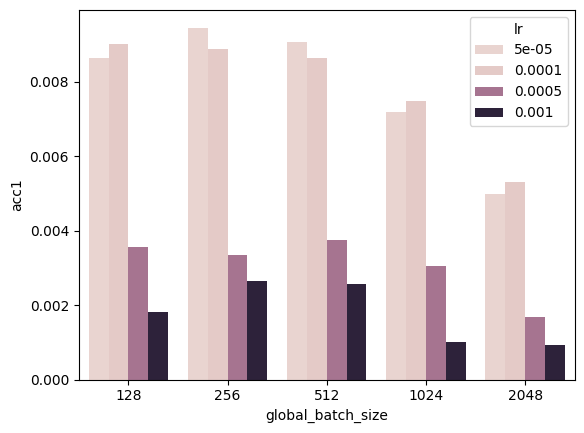

In [240]:
d = results[results.total_epochs==results.epoch].copy()
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d = d[d.samples_seen_scale=="1.28M"]
sns.barplot(x="global_batch_size", y="acc1", hue="lr", data=d, estimator="max", errorbar=None)

<Axes: xlabel='global_batch_size', ylabel='acc1'>

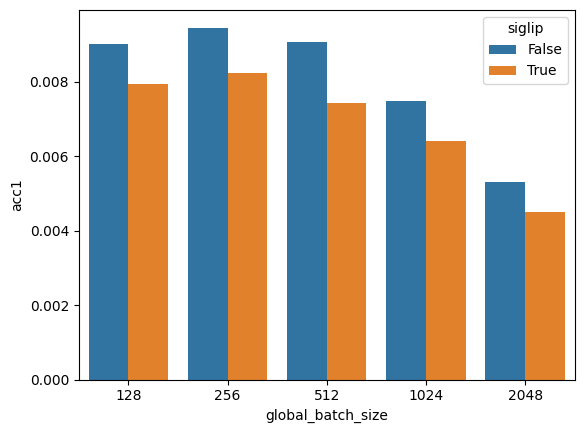

In [245]:
d = results[results.total_epochs==results.epoch].copy()
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d = d[d.samples_seen_scale=="1.28M"]
sns.barplot(x="global_batch_size", y="acc1", hue="siglip", data=d, estimator="max", errorbar=None)

In [253]:
d = results[results.total_epochs==results.epoch].copy()
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d = d[d.samples_seen_scale=="1.28M"]
#d = d[d.samples_seen_scale=="128M"]
d["name"] = d["name"].apply(lambda n:n.replace("sigTrue", "").replace("sigFalse", ""))
d = d.pivot(index="name", columns="siglip", values="acc1")
d = d.style.highlight_max(color='lightgreen', axis=1)
d

siglip,False,True
name,,
datacomp_s1.28M_ViT-B-32_ep10_lr0.0001_b1_0.9_b2_0.95_wd0.2_w10_gc1_n16_bs16_,0.007500,0.005340
datacomp_s1.28M_ViT-B-32_ep10_lr0.0001_b1_0.9_b2_0.95_wd0.2_w10_gc1_n16_bs2_,0.009020,0.007480
datacomp_s1.28M_ViT-B-32_ep10_lr0.0001_b1_0.9_b2_0.95_wd0.2_w10_gc1_n16_bs32_,0.005300,0.003500
datacomp_s1.28M_ViT-B-32_ep10_lr0.0001_b1_0.9_b2_0.95_wd0.2_w10_gc1_n16_bs4_,0.008880,0.008240
datacomp_s1.28M_ViT-B-32_ep10_lr0.0001_b1_0.9_b2_0.95_wd0.2_w10_gc1_n16_bs8_,0.008640,0.007280
datacomp_s1.28M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w10_gc1_n16_bs16_,0.001700,0.003040
datacomp_s1.28M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w10_gc1_n16_bs2_,0.003460,0.003560
datacomp_s1.28M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w10_gc1_n16_bs32_,0.000860,0.001680
datacomp_s1.28M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w10_gc1_n16_bs4_,0.002700,0.003340


In [243]:
d = results[results.total_epochs==results.epoch]

ds = 'wds/mscoco_captions'
metric = 'image_retrieval_recall@5'

d = d[d.downstream_dataset==ds]
d[[metric] + cols].sort_values(by=metric, ascending=False).round(4)

,image_retrieval_recall@5,model,samples_seen_scale,downstream_dataset,lr,gflops_total,siglip,gpus,batch_size,global_batch_size,samples_per_sec,training_time_hours,total_steps,name
1029,0.5189,ViT-B-32,1.28B,wds/mscoco_captions,0.0010,1.891840e+10,False,256,354,90624,213148.3302,1.6681,14124,datacomp_s1.28B_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse
1009,0.5053,ViT-B-32,1.28B,wds/mscoco_captions,0.0010,1.891840e+10,True,256,354,90624,152083.8906,2.3379,14124,datacomp_s1.28B_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigTrue
989,0.4828,ViT-B-32,1.28B,wds/mscoco_captions,0.0005,1.891840e+10,False,256,354,90624,212576.2874,1.6726,14124,datacomp_s1.28B_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse
969,0.4733,ViT-B-32,1.28B,wds/mscoco_captions,0.0005,1.891840e+10,True,256,354,90624,150823.7082,2.3574,14124,datacomp_s1.28B_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigTrue
949,0.3391,ViT-B-32,128M,wds/mscoco_captions,0.0010,1.891840e+09,False,256,64,16384,83510.9708,0.4258,7812,datacomp_s128M_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigFalse
929,0.3307,ViT-B-32,128M,wds/mscoco_captions,0.0010,1.891840e+09,True,256,64,16384,48774.9022,0.7290,7812,datacomp_s128M_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigTrue
909,0.3134,ViT-B-32,128M,wds/mscoco_captions,0.0005,1.891840e+09,False,256,64,16384,83722.2685,0.4247,7812,datacomp_s128M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigFalse
889,0.3071,ViT-B-32,128M,wds/mscoco_captions,0.0005,1.891840e+09,True,256,64,16384,48849.7213,0.7279,7812,datacomp_s128M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigTrue
829,0.0787,ViT-B-32,12.8M,wds/mscoco_captions,0.0005,1.891840e+08,False,64,64,4096,25565.6708,0.1391,3125,datacomp_s12.8M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w100_gc1_n16_bs64_sigFalse
809,0.0680,ViT-B-32,12.8M,wds/mscoco_captions,0.0005,1.891840e+08,True,64,64,4096,20597.0559,0.1726,3125,datacomp_s12.8M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w100_gc1_n16_bs64_sigTrue


# Downstream Task Learning curves

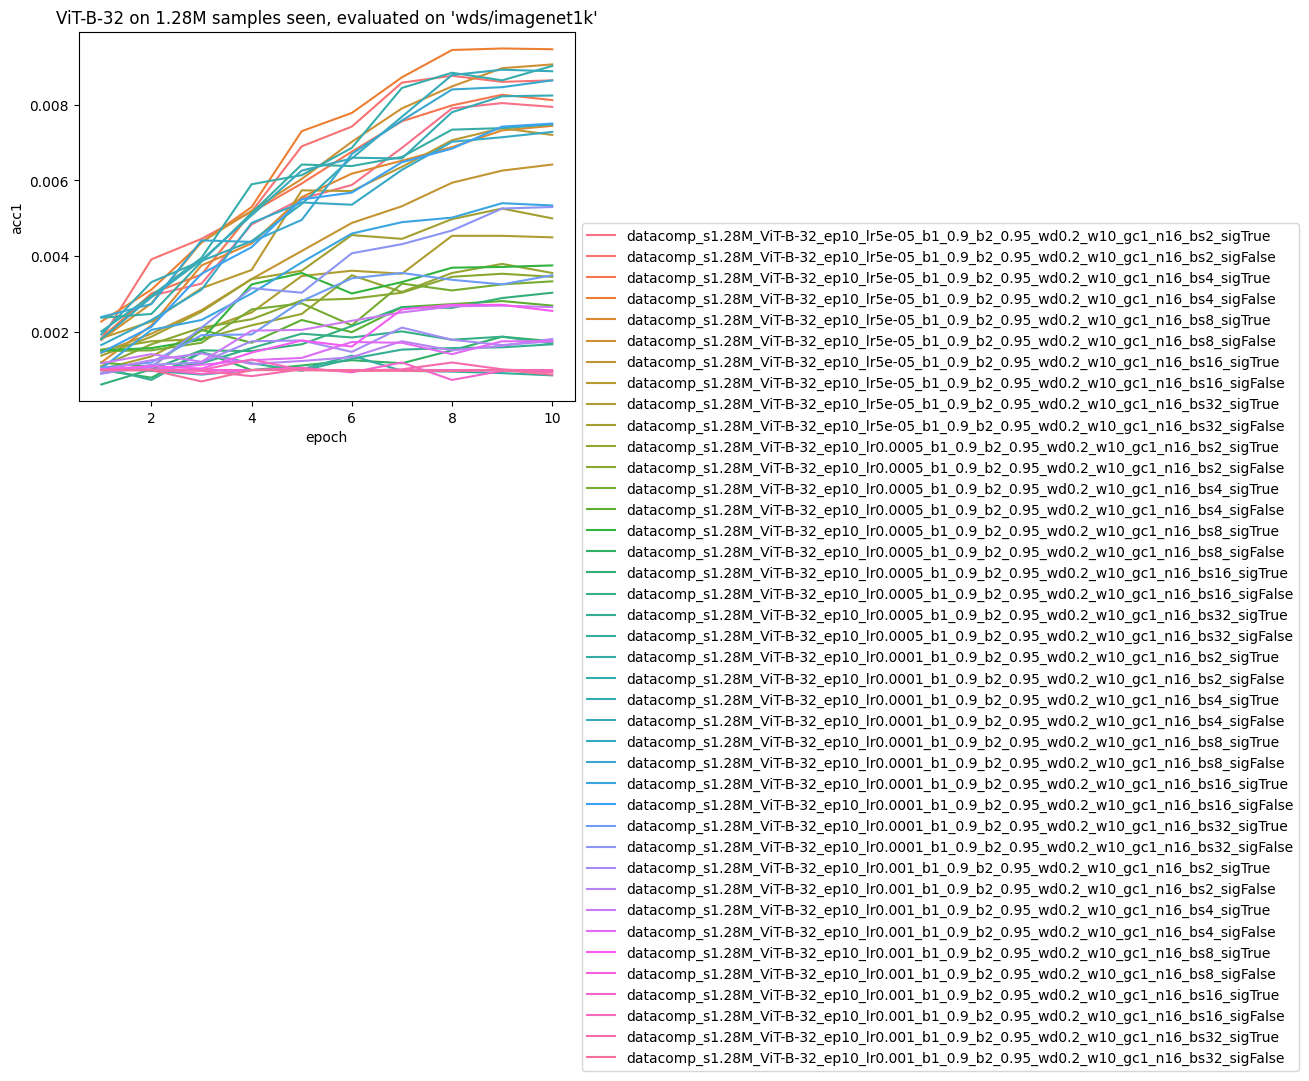

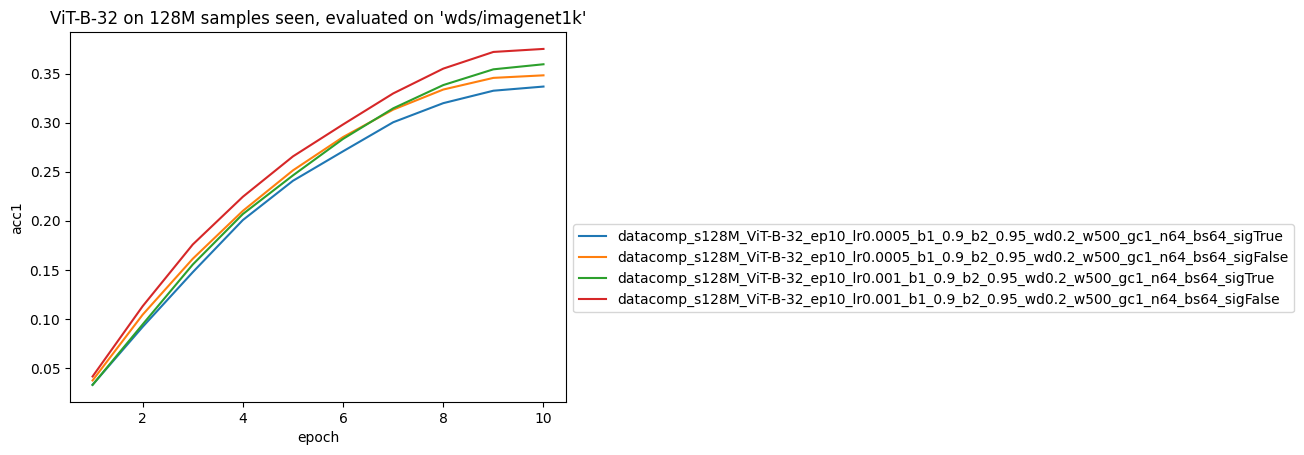

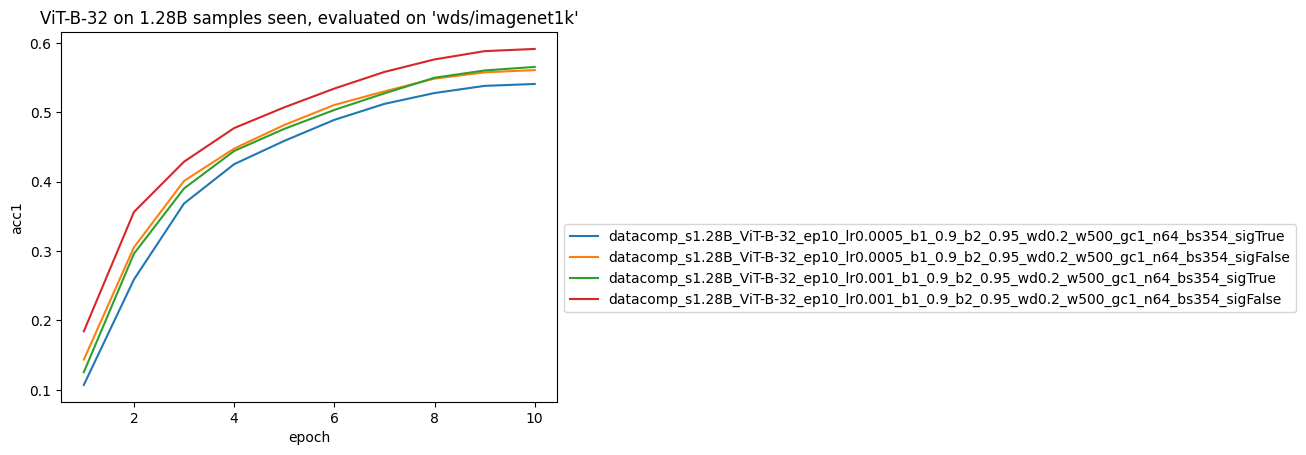

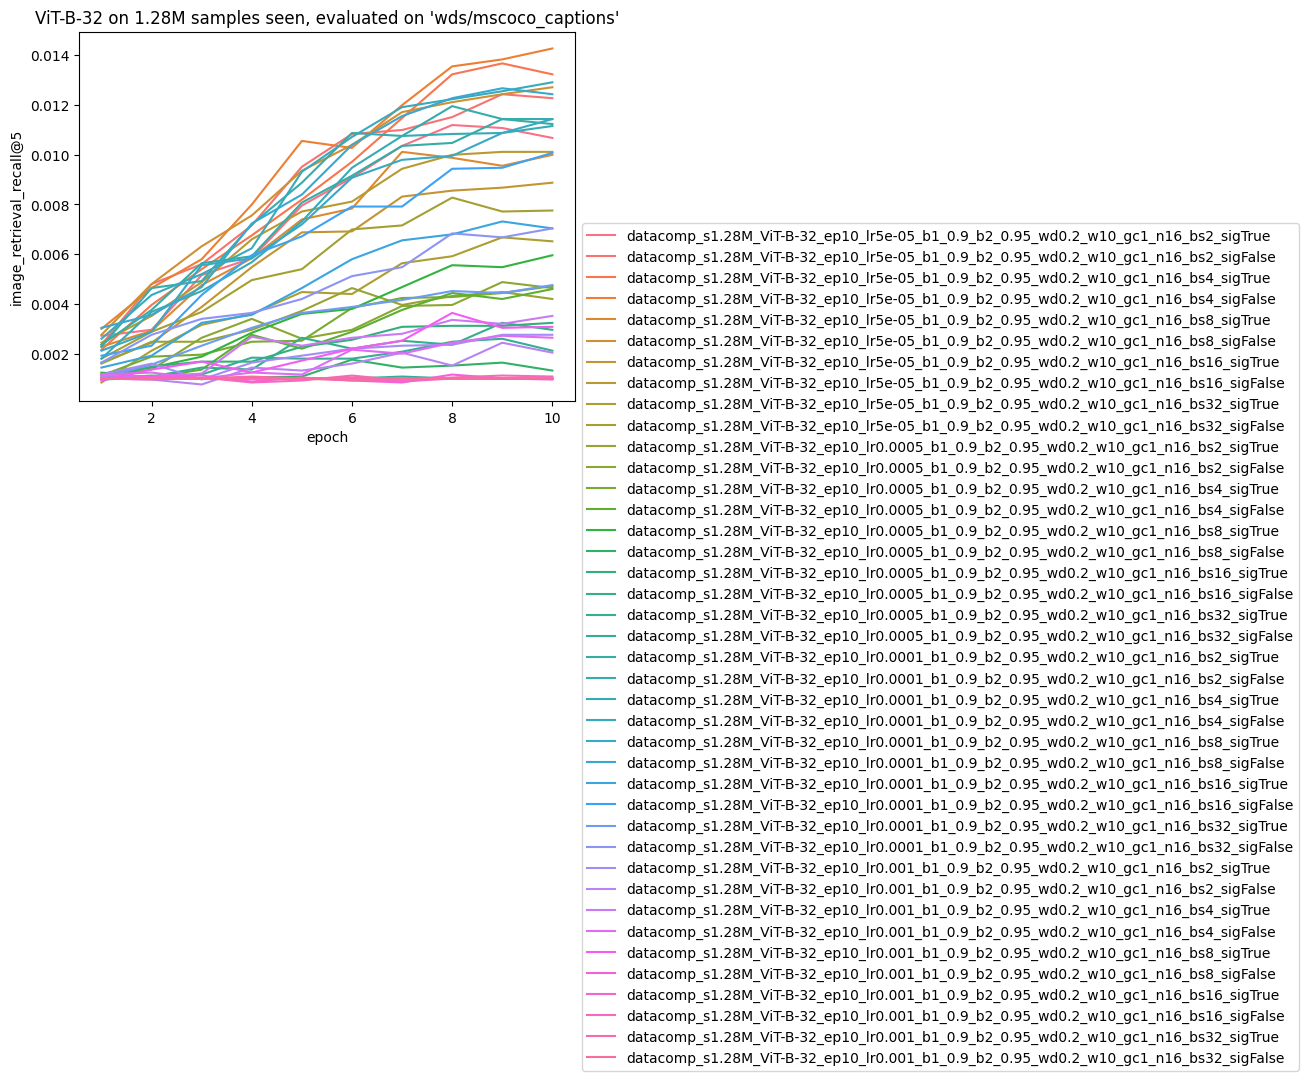

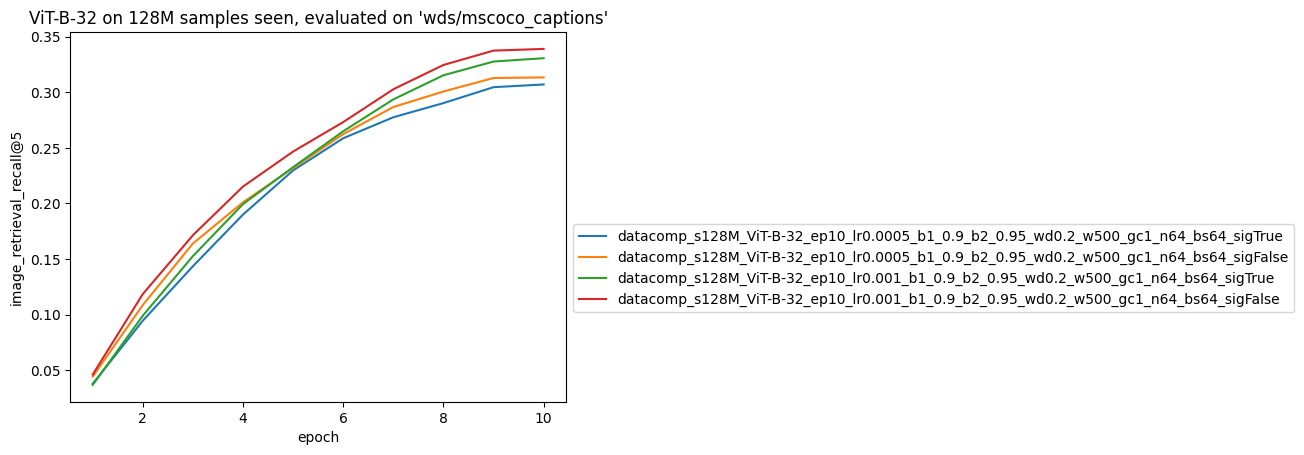

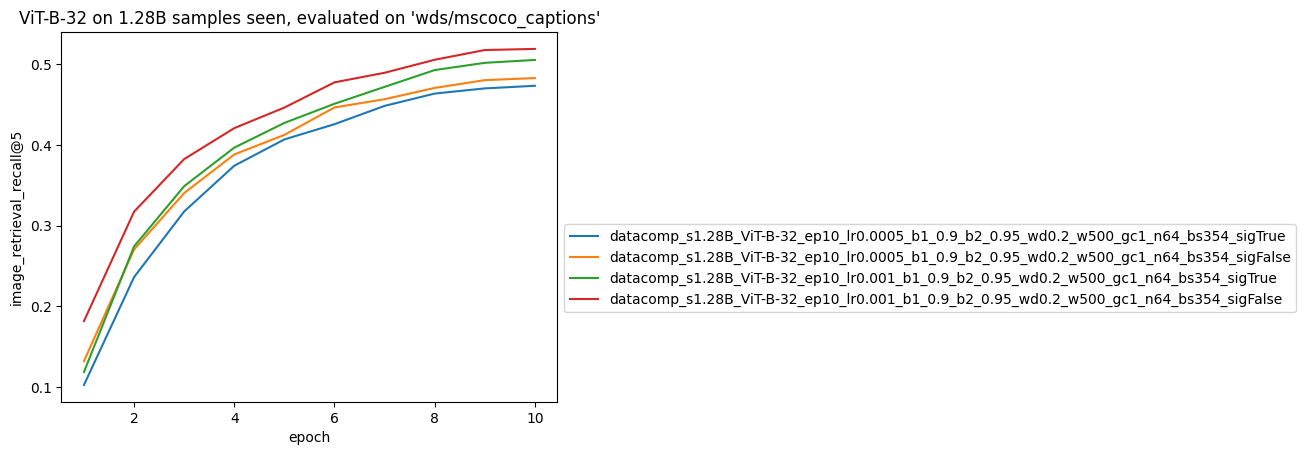

In [208]:
for model in ("ViT-B-32",):
    for (ds, metric) in ( ("wds/imagenet1k", "acc1"), ("wds/mscoco_captions", "image_retrieval_recall@5")):
        for samples_seen in ("1.28M", "128M", "1.28B"):
            d = results
            d = d[(d.model == model) & (d.samples_seen_scale==samples_seen) & (d.downstream_dataset==ds)]
            sns.lineplot(x="epoch", y=metric, data=d, hue="name")
            #d = d.sort_values(by='epoch')
            #d.plot(x='epoch', y=metric)
            plt.title(f"{model} on {samples_seen} samples seen, evaluated on '{ds}'")
            plt.legend(bbox_to_anchor=(1,0.5))
            plt.show()

# Scaling curve

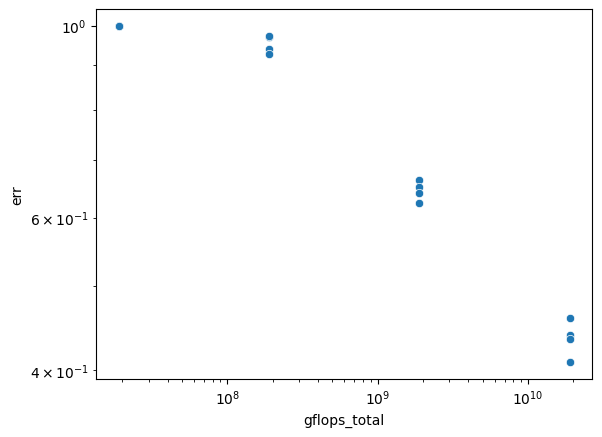

In [204]:
d = results[results.total_epochs==results.epoch]
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d["err"] = 1 - d[metric]
sns.scatterplot(x="gflops_total", y="err", data=d)
plt.xscale("log")
plt.yscale("log")